# Gaussian Mixture Model

Consider a set of data containing a mixture of $K$ 1d-gaussians with different $\mu_k$ and $\sigma_k$. Denote $z_i$ as the particular gaussian that the i-th particle comes from, which is modeled as Dirichlet distribution with some fixed parameter $\alpha$.  
Mathematically, 

\begin{gather*}
z_i \sim \text{Categorical}(\pi)\\
\pi \sim Dir(\alpha)\\
x_i|\mathbf{\mu}, z_i \sim \mathcal{N}(\mathbf{c}^T\mathbf{\mu}, \mathbf{\sigma})
\end{gather*}

Let's visualize the data.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

class gaussian_mixture_model_1d:
    def __init__(self):
        self.mixtures = dict() # true model of all gaussians
        self.samples = dict() # corresponding samples

    def add_gaussian(self, mean, sigma):
        model = stats.multivariate_normal(mean, cov=sigma)
        self.mixtures[(mean,sigma)] = model
     
    def draw_sample(self, sizes):
        if isinstance(sizes, int):
            sizes = [sizes]
        sizes = list(sizes)
        
        while len(sizes) < len(self.mixtures):
            sizes.append(sizes[-1])
        
        for i, (key, model) in enumerate(self.mixtures.items()):
            self.samples[key] = model.rvs(size = sizes[i])

        return self.samples

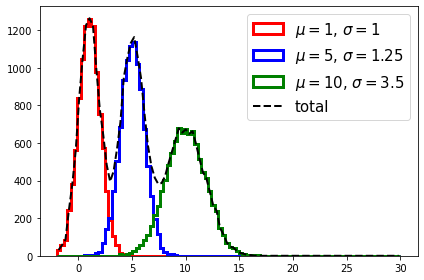

In [2]:
gmm = gaussian_mixture_model_1d()
gmm.add_gaussian(1, 1)
gmm.add_gaussian(5, 1.25)
gmm.add_gaussian(10, 3.5)
datum  = gmm.draw_sample(10000)

fig, ax = plt.subplots()
obs_data = np.empty(0)
colors = ['r', 'b', 'g']
for i, (key, data) in enumerate(datum.items()):
    ax.hist(data, range=(-2,30), bins=100, histtype = 'step', label=r'$\mu={mean}$, $\sigma={var}$'.format(mean=key[0],var=key[1]), color=colors[i], linewidth=3)
    obs_data = np.concatenate((obs_data, data))

hist, edges = np.histogram(obs_data, range=(-2,30), bins=100)
x = 0.5 * (edges[1:] + edges[:-1])
ax.errorbar(x, y=hist, fmt='k--', label='total', linewidth=2,)
plt.legend(fontsize=15)
plt.tight_layout()

In [3]:
from sklearn.mixture import BayesianGaussianMixture
dpgmm = BayesianGaussianMixture(n_components=3, random_state=0)
np.random.shuffle(obs_data)
obs_data = obs_data.reshape(-1,1)
dpgmm.fit(obs_data)
dpgmm.means_



array([[1.01175363],
       [9.98773108],
       [5.01611317]])

In [4]:
from sklearn.mixture import GaussianMixture
dpgmm = GaussianMixture(n_components=3, random_state=0)
np.random.shuffle(obs_data)
obs_data = obs_data.reshape(-1,1)
dpgmm.fit(obs_data)
dpgmm.means_

array([[ 5.10926509],
       [10.16428372],
       [ 1.01603907]])

In [6]:
class test:
    def __init__(self, n_components=1, max_iter=100):
        self.n_components = n_components
        self.max_iter = max_iter


    def _initialize(self, X):
        self.pi = [1 / self.n_components for i in range(self.n_components)]
        n_samples, _ = X.shape
        self.qz = np.zeros(shape=(n_samples, self.n_components))
        for n in range(n_samples):
            k = np.random.randint(0, self.n_components)
            self.qz[n][k] = 1
            
        nk, xk, vk = self._estimate_gaussian_parameters(X, self.qz)
        self.pi = nk / np.sum(nk)
        self.means_ = xk
        self.precisions_ = 1./vk

    def _estimate_gaussian_parameters(self, X, qz):
        
        nk = np.sum(qz, axis=0)
        means = np.dot(qz.T, X) / nk[:, np.newaxis]
        var = np.empty(shape=self.n_components)
        for k in range(self.n_components):
            diff = X - means[k]
            var[k] = np.dot(qz[:, k] * diff.T, diff) / nk[k]
        
        return nk, means, var


    def fit(self, X):
        self._initialize(X)
        n_samples, _ = X.shape
        
        for i in range(self.max_iter):
            for n in range(n_samples):
                for k in range(self.n_components):
                    # self.qz[n][k] = self.pi[k] * np.sqrt(self.precisions_[k])  * np.exp(-0.5 * (X[i] - self.means_[k])**2 * self.precisions_[k])
                    self.qz[n][k] = self.pi[k] * stats.multivariate_normal(mean=self.means_[k], cov=1./self.precisions_[k]).pdf(X)

                self.qz[n] /= np.sum(self.qz[n])

            nk, xk, vk = self._estimate_gaussian_parameters(X, self.qz)
            self.pi = nk / np.sum(nk)
            self.means_ = xk
            self.precisions_ = 1./vk
        

t = test(3, max_iter=10)
t.fit(obs_data)
t.means_

        


        




ValueError: setting an array element with a sequence.

In [ ]:
def normal_distribution(x, mean, precision):
    return np.sqrt(precision / 2. / np.pi) * np.exp(-0.5 * (x-mean)**2 * precision)

class BasicGMM:
    def __init__(self, n_components=1, max_iter=100, tol=1e-3):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):

        self._initialize_parameters(X)
        tol = 1e3
        iter = 0

        while tol > self.tol and iter < self.max_iter:
            qz = self._e_step(X)
            self._m_step(X, qz)
            iter += 1
            # print(iter)
        return self 

    def _initialize_parameters(self, X):
        n_samples, _ = X.shape
        qz = np.zeros(shape=(n_samples, self.n_components))
        for n in range(n_samples):
            k = np.random.randint(0, self.n_components)
            qz[n][k] = 1

        self._initialize(X, qz)

    def _initialize(self, X, qz):
        nk, xk, vk = self._estimate_gaussian_parameters(X, qz)
        self.pi = nk / np.sum(nk)
        self.means_ = xk
        self.precisions_ = 1./vk

    def _estimate_gaussian_parameters(self, X, qz):
        
        nk = np.sum(qz, axis=0)
        means = np.dot(qz.T, X) / nk[:, np.newaxis]
        var = np.empty(shape=self.n_components)
        for k in range(self.n_components):
            diff = X - means[k]
            var[k] = np.dot(qz[:, k] * diff.T, diff) / nk[k]
        
        return nk, means, var

    def _e_step(self, X):
        n_samples, _ = X.shape
        qz = np.empty(shape=(n_samples, self.n_components))
        for n in range(n_samples):
            for k in range(self.n_components):
                qz[n][k] = self.pi[k] * normal_distribution(X[n], self.means_[k], self.precisions_[k])
            qz[n] /= np.sum(qz[n])
        return qz

    def _m_step(self, X, qz):
        self._initialize(X, qz)
        print(self.means_)
        

gmm = BasicGMM(3)
gmm.fit(obs_data)

As seen from the figure, the data we can observe would be the sum of the gaussian distributions. If these gaussians are close then we could not distinguish them from being one gaussian or a mixture of gaussian. Our goal, as usual, is to calculate the posterior given the data. The problem would be as easy as one single gaussian if we know which gaussian each data point comes from. In reality we don't, thus we need to introduce the latent variables.

## Mean field Variational inference for GMM
 In our case, we know or we want to group the data into $K$ gaussian, what we want to learn is the posterior for variable $X$, latent variables $Z$ which tells us which gaussian it belongs to, and finally $\pi$ the pdf of these gaussians. Our probablistic model is
\begin{equation*}
p(X, Z, \pi|\mu, \sigma) = p(\pi)\prod_{i=1}^{N} p(z_i|\pi) p(x_i|z_i,\mu,\sigma) = Dir(\pi|\alpha) \prod_{i=1}^N \prod_{k=1}^K \big[\pi_k \mathcal{N}(x_i|\mu_k, \sigma_k)\big]^{z_{ik}}
\end{equation*}
Note that $z_{ik}$ is either 1 or 0 to pick the gaussian from which the data point belongs to.

#### Test for conjugacy
First, we need to verify that GMM satisfy conditional conjugacy. Namely, if we fix $Z$, the prior has the form
\begin{gather*}
\text{prior:} \qquad p(\pi,Z) = p(\pi) \prod_{i=1}^N p(z_i|\pi) = Dir(\pi|\alpha) \prod_{i=1}^N\prod_{k=1}^K \pi_k^{z_{ik}} = C\prod_{k=1}^K \pi_k^C \\
\text{posterior:} \qquad p(Z,\pi|X) \propto p(X,Z,\pi) = Dir(\pi|\alpha)  \prod_{i=1}^N\prod_{k=1}^K C^{z_{ik}} \pi_k^{z_{ik}} = C\prod_{k=1}^K \pi_k^C
\end{gather*}

where $\prod_{i=1}^N \pi_k^{z_{ik}} \rightarrow \prod_{i=1}^N \pi_k^C \rightarrow \pi_k^C$, all C represent differenet constants. If we fix $\pi$, then
\begin{gather*}
\text{prior:} \qquad p(\pi,Z) = p(\pi) \prod_{i=1}^N p(z_i|\pi) = Dir(\pi|\alpha) \prod_{i=1}^N\prod_{k=1}^K \pi_k^{z_{ik}} = C\prod_{i=1}^N\prod_{k=1}^K C^{z_{ik}} \\
\text{posterior:} \qquad p(Z,\pi|X) \propto p(X,Z,\pi) = Dir(\pi|\alpha)  \prod_{i=1}^N\prod_{k=1}^K C^{z_{ik}} \pi_k^{z_{ik}} = C \prod_{i=1}^N\prod_{k=1}^K C^{z_{ik}}
\end{gather*}
Therefore, it is ok to apply block coordinate ascent. Next we proceed to get the update rule for $q(Z)$ and $q(\pi)$.

## EM Algorithm
In a mean-field approximation, we neglect any correlation between the latent variables, very much like the mean-field approximation in many body problem which allows us to diagonalize the Hamiltonian. Mathematically, $q(Z,\pi) = q(Z)q(\pi)$. Here, the model involves X, latent variables Z and $\pi$ and parameters of the gaussians. In case like this, it is suggested to use the Expectation-Maximization (EM) algorithm in which the E-step updates the pdf of latent variables (using Coordinate Ascent for Variational Inference) and the M-step optimizes the parameters. In this ipynb, I take this approach as axiom and possibly will study the 'proof' later. 

#### E-step : Update Rule for $q(Z)$ and $q(\pi)$
The alogorithm of "Coordinate Ascent for Variational Inference" tells us the update rule for each latent variables : 
\begin{equation*}
q_k(\theta_k) \propto \exp\bigg[\mathbb{E}_{q_{-k}(\theta_{-k})}\log p(\theta,x) \bigg]
\end{equation*}

In our case, 
\begin{align*}
\log q(\pi) &= \mathbb{E}_{q(Z)}\log p(X, Z, \pi) + \text{const} \\ 
&= \mathbb{E}_{q(Z)} \bigg[ \sum_{k=1}^K (\alpha_k-1)\log \pi_k + \sum_{i=1}^N\sum_{k=1}^K z_{ik}\log \pi_k \bigg] + \text{const}\\
&= \sum_{k=1}^K (\alpha_k-1)\log \pi_k + \sum_{i=1}^N\sum_{k=1}^K \mathbb{E}_{q(Z)}z_{ik} \log \pi_k + \text{const} \\
&= \sum_{k=1}^K \log \pi_k \bigg( \alpha_k -1 + \sum_{i=1}^N \mathbb{E}_{q(Z)}z_{ik} \bigg) + \text{const}
\end{align*}

where we have used the relation $Dir(\pi|\alpha) \propto \prod_{k=1}^K \pi_k^{\alpha_k-1}$ before taking the log. Due to the conditional conjugacy $q(\pi)$ would have the same form as prior and thus we get the update rule :
\begin{gather*}
q(\pi) = Dir(\pi | \alpha')\\
\alpha_k' = \alpha_k + \sum_{i=1}^N \mathbb{E}_{q(Z)} z_{ik}  = \alpha_k + \sum_{i=1}^N q(z_{ik}=1)
\end{gather*}




The update rule for $q(Z)$:
\begin{align*}
    \log q(Z) &= \mathbb{E}_{q(\pi)}\log p(X, Z, \pi) + \text{const} \\ 
    &= \mathbb{E}_{q(\pi)} \sum_{i=1}^N\sum_{k=1}^K z_{ik}\bigg[\log \pi_k + \log \mathcal{N}(x_i| \mu_k,\sigma_k) \bigg] + \text{const}\\
    &= \sum_{i=1}^N\sum_{k=1}^K z_{ik}\bigg[\mathbb{E}_{q(\pi)} \log \pi_k + \log \mathcal{N}(x_i| \mu_k,\sigma_k) \bigg] + \text{const} \\
    &= \sum_{i=1}^N\sum_{k=1}^K z_{ik}\log \rho_{ik} + \text{const}
\end{align*} 

where we denote $\log \rho_{ik} = \mathbb{E}_{q(\pi)} \log \pi_k + \log \mathcal{N}(x_i| \mu_k,\sigma_l)$ since again by conjugacy we know $q(Z)$ is categorical. We can see that 
\begin{gather*}
q(Z)\propto \prod_{i=1}^N\prod_{k=1}^K \rho_{ik}^{z_{ik}}
\end{gather*}

We can then normalize by using $\sum_{k=1}^K p(z_{ik}=1) = \sum_{k=1}^K \rho_{ik}= 1$, i.e.
\begin{gather*}
q(Z)= \prod_{i=1}^N\prod_{k=1}^K \bigg(\frac{\rho_{ik}}{\sum_{l=1}^K \rho_{il}}\bigg)^{z_{ik}} \\
\rho_{ik} = \mathbb{E}_{q(\pi)} \log \pi_k + \log \mathcal{N}(x_i|\mu_k,\sigma_k)
\end{gather*}

Note that the expectation term in $\rho_{ik}$ can be calculated with the update rule of $q(\pi)$. 

#### M-step : Maximize ELBO with respect to parameters
In M-step, we use the $q(Z)$ found in E-step to optimize:
\begin{equation*}
\theta^{\text{NEW}} = \argmax_{\theta} \mathbb{E}_{p(Z)} \log p(X,Z; \theta)
\end{equation*}
The expectation value, dropping the term independent of $\mu, \sigma$, is
\begin{align*}
\mathbb{E}_{p(Z,\pi)} \log p(X,Z,\pi; \mu, \sigma) &= \mathbb{E}_{p(Z,\pi)} \log\bigg( Dir(\pi|\alpha) \prod_{i=1}^N \prod_{k=1}^K \big[\pi_k \mathcal{N}(x_i|\mu_k, \sigma_k)\big]^{z_{ik}}\bigg) \\
&= \mathbb{E}_{p(Z,\pi)} \bigg[ \log Dir(\pi|\alpha) + \sum_{i=1}^N\sum_{k=1}^K z_{ik}\log\pi_k + z_{ik}\log \mathcal{N}(x_i|\mu_k,\sigma_k) \bigg]\\
&= \sum_{i=1}^N\sum_{k=1}^K \mathbb{E}_{p(Z)}z_{ik}\log \mathcal{N}(x_i|\mu_k,\sigma_k) + \text{const}\\
&=\sum_{i=1}^N\sum_{k=1}^K \mathbb{E}_{p(Z)}z_{ik} \bigg( -\log \sigma_k - \frac{(x_i-\mu_k)^2}{2\sigma_k^2}\bigg) + \text{const}\\
&=\sum_{i=1}^N\sum_{k=1}^K\gamma_{ik} \bigg( -\log \sigma_k - \frac{(x_i-\mu_k)^2}{2\sigma_k^2}\bigg) + \text{const}
\end{align*}


The expectation of Dirichlet distribution does not depend on $\mu$ and $\sigma$, thus is regarded as constant. Variate with respect to $\mu_k$, 
\begin{align*}
\sum_{i=1}^N\gamma_{ik} \frac{x_i-\mu_k}{\sigma_k^2} = 0 \implies \mu_k = \frac{\sum_{i=1}^N \gamma_{ik}x_i}{\sum_{i=1}^N\gamma_{ik}}
\end{align*}


Variate with respect to $\sigma_k$,
\begin{align*}
\sum_{i=1}^N\gamma_{ik}\bigg(-\frac{1}{\sigma_k} + \frac{3(x_i-\mu_k)^2}{\sigma_k^3}\bigg) = 0 \implies \sigma_k^2 = \frac{\sum_{i=1}^N3\gamma_{ik}(x_i-\mu_k)^2}{\sum_{i=1}^N\gamma_{ik}}
\end{align*}

In [ ]:
import numpy as np
from scipy import special
from scipy import stats

class Dirichlet_GMM1D:
    def __init__(self, n_components=1, tol=1e-3, max_iter=100):
        self.n_components = n_components # number of mixture
        self.max_iter = max_iter # number of max iter
        self.tol = tol

    def fit(self, X):
        self._initialize(X)
        tol = 1e3
        iter = 0

        while tol > self.tol and iter < self.max_iter:
            self._Estep(X)
            self._Mstep(X)
            iter += 1
            print(iter)
        return self 

    def _initialize(self, X):

        self.alpha = np.full(shape=self.n_components, fill_value=1./self.n_components)
        n_samples, _ = X.shape
        self.qZ = np.zeros(shape=(n_samples, self.n_components))
        for n in range(n_samples):
            k = np.random.randint(0, self.n_components)
            self.qZ[n][k] = 1

        self._update_mean(X)
        self._update_precision(X)

    def _Estep(self, X):
        self._update_qz(X)
        self._update_qpi(X)

    def _Mstep(self, X):
        self._update_mean(X)
        self._update_precision(X)

    def _update_qz(self, X):
        n_samples, _ = X.shape
        for i in range(n_samples):
            for k in range(self.n_components):
                # log_norm = np.log(self._normal(X[i], self.means[k], self.var[k]))
                log_norm = -0.5 * np.log(self.var[k]) - (X[i]-self.means[k])**2 / 2. /self.var[k] 
                Eq_logpi = special.digamma(self.alpha[k]) - special.digamma(np.sum(self.alpha))
                self.qZ[i][k] = Eq_logpi + log_norm

            self.qZ[i] /= np.sum(self.qZ[i])
        print(self.qZ)
        return self.qZ

    # def _normal(self, x, mean, var):
    #     return (2*np.pi*var)**(-1/2) * np.exp(-(x-mean)**2/2./var)

    def _update_qpi(self, X):
        nk = np.sum(self.qZ, axis=0)
        self.alpha += nk
        return self.alpha

    def _update_mean(self, X):
        # n_samples, _ = X.shape
        # for k in range(self.n_components):
        #     for i in range(n_samples):
        #         self.means[k] += self.qZ[i][k] * X[i]
        #     self.means[k] /= np.sum(self.qZ, axis=0)[k]

        nk = np.sum(self.qZ, axis=0)
        self.means = np.dot(self.qZ.T, X) / nk[:, np.newaxis]
        print(self.means)
        return self.means

    def _update_precision(self, X):
        nk = np.sum(self.qZ, axis=0)
        self.var = np.empty(shape=self.n_components)
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.var[k] = np.dot(self.qZ[:, k] * diff.T, diff) / nk[k]

        self.precision = 1./self.var[k]
        return self.precision
        

# our model
K = 3
np.random.shuffle(obs_data)
dir_gmm = Dirichlet_GMM1D(n_components=K, max_iter=5)
dir_gmm.fit(obs_data)
